<a href="https://colab.research.google.com/github/mshojaei77/LLMs-Journey/blob/main/ch1/Embedding_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing Different Embedding Techniques: Word2Vec, GloVe, and FastText

Word embeddings are fundamental in Natural Language Processing (NLP) as they transform words into numerical vectors, enabling machines to comprehend and process human language. This notebook provides a practical comparison of three popular embedding techniques: **Word2Vec**, **GloVe**, and **FastText**. We will explore their architectures, load pre-trained models, visualize embeddings, and evaluate their performance on a text classification task.

In [ ]:
# Install required packages
!pip install gensim
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install tqdm

In [3]:
# Importing Libraries
import gensim
import gensim.downloader as api
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

## Loading Pre-trained Embeddings

We will use pre-trained models for all three embedding techniques to ensure a fair comparison.


### Word2Vec

In [4]:
# Loading Pre-trained Word2Vec Model
print("Loading Word2Vec model...")
word2vec_model = api.load("word2vec-google-news-300")  # This may take a while
print("Word2Vec model loaded successfully.")

Loading Word2Vec model...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec model loaded successfully.


### GloVe


In [5]:
# Loading Pre-trained GloVe Model
print("Loading GloVe model...")
glove_vectors = api.load("glove-wiki-gigaword-300")  # 300-dimensional GloVe vectors
print("GloVe model loaded successfully.")

Loading GloVe model...
[==================================================] 100.0% 376.1/376.1MB downloaded
GloVe model loaded successfully.


### FastText

In [6]:
# Loading Pre-trained FastText Model
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")  # 300-dimensional FastText vectors
print("FastText model loaded successfully.")

Loading FastText model...
[==================================================] 100.0% 958.5/958.4MB downloaded
FastText model loaded successfully.


## Embedding Comparison

### Vector Similarities

Let's compare how each embedding captures semantic relationships. We'll compute the cosine similarity between some sample word pairs.


In [7]:

from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(model, word1, word2):
    try:
        return cosine_similarity([model[word1]], [model[word2]])[0][0]
    except KeyError:
        return None

# Sample word pairs
word_pairs = [
    ("king", "queen"),
    ("man", "woman"),
    ("paris", "france"),
    ("apple", "orange"),
    ("computer", "keyboard"),
    ("city", "village"),
    ("car", "bicycle"),
    ("happy", "joyful"),
    ("sad", "unhappy"),
    ("run", "jog")
]

# Function to display similarities
def display_similarities(pairs, models, model_names):
    similarities = {name: [] for name in model_names}
    for word1, word2 in pairs:
        for model, name in zip(models, model_names):
            sim = get_similarity(model, word1, word2)
            similarities[name].append(sim)

    df = pd.DataFrame(similarities, index=[f"{w1} vs {w2}" for w1, w2 in pairs])
    display(df)

model_list = [word2vec_model, glove_vectors, fasttext_model]
model_names = ["Word2Vec", "GloVe", "FastText"]

display_similarities(word_pairs, model_list, model_names)

,Word2Vec,GloVe,FastText
king vs queen,0.651096,0.633647,0.770425
man vs woman,0.766401,0.699866,0.811981
paris vs france,0.555080,0.658067,0.666740
apple vs orange,0.392035,0.320602,0.561822
computer vs keyboard,0.396392,0.441461,0.609826
city vs village,0.478969,0.430027,0.624059
car vs bicycle,0.536448,0.497951,0.606432
happy vs joyful,0.423820,0.475132,0.712874
sad vs unhappy,0.415723,0.484770,0.730454
run vs jog,0.268781,0.176934,0.438383


### Dimensionality Reduction and Visualization

We'll reduce the embedding dimensions to 2D using PCA for visualization purposes.

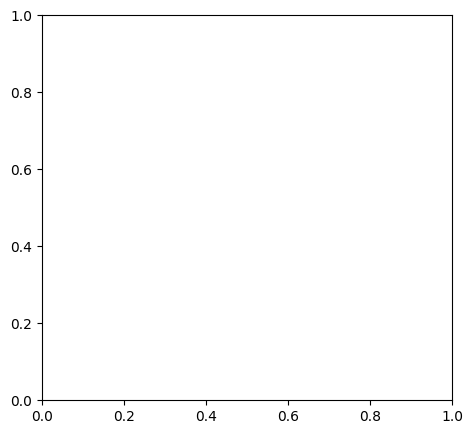

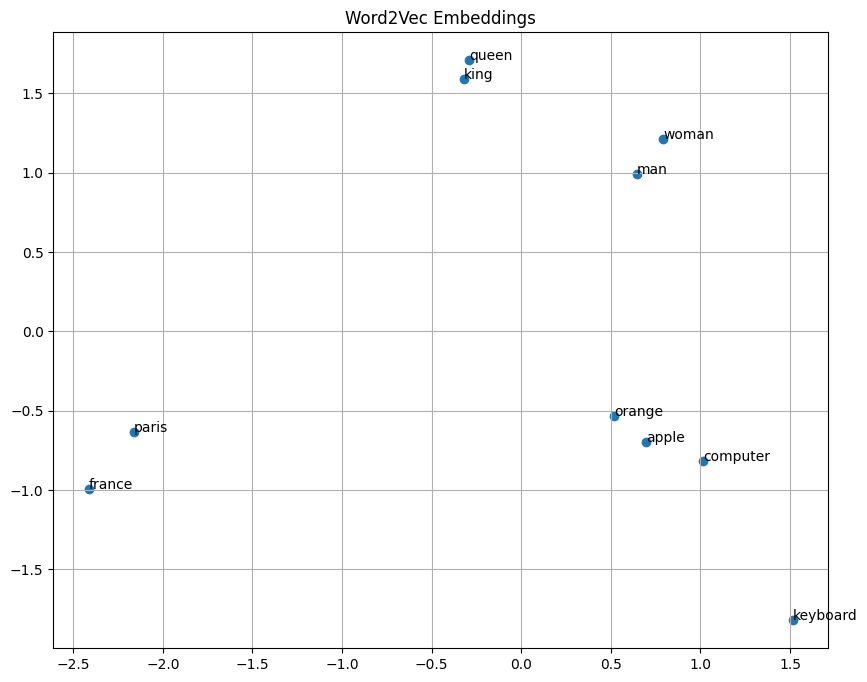

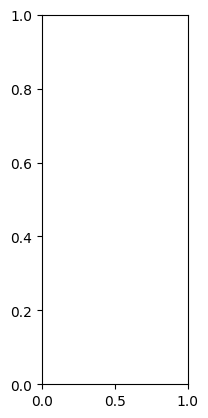

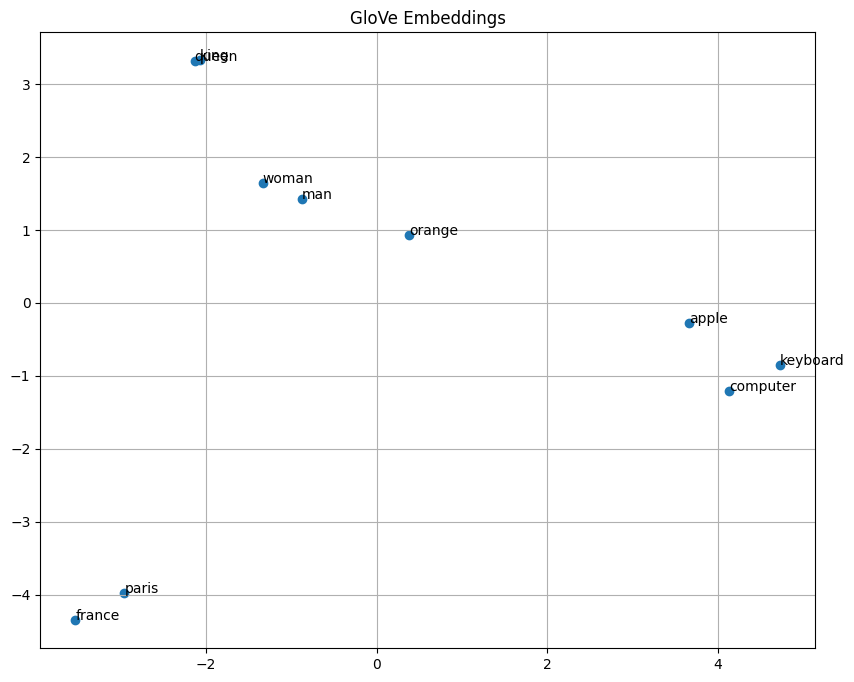

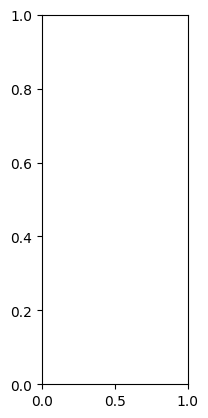

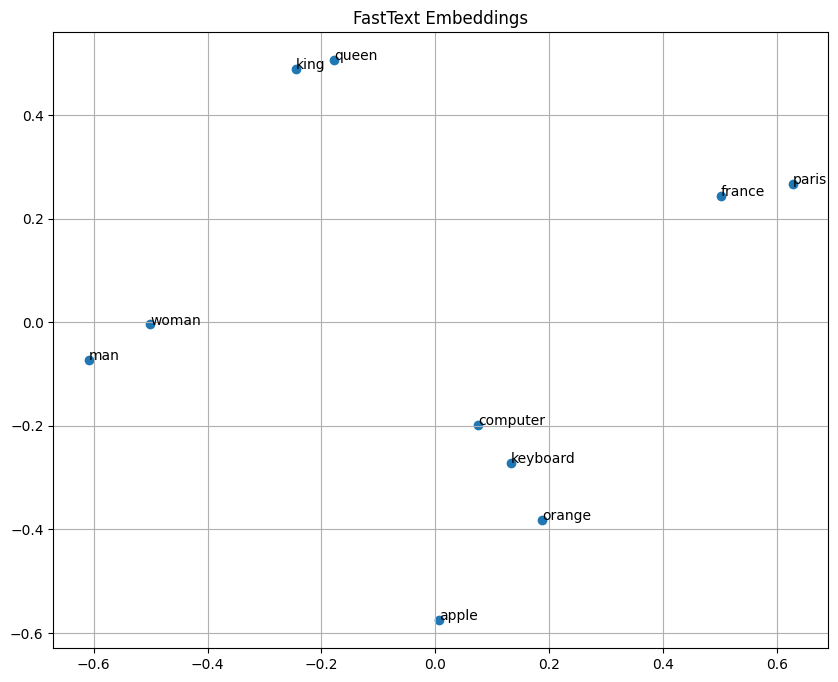

<Figure size 640x480 with 0 Axes>

In [8]:
from sklearn.decomposition import PCA

def visualize_embeddings(model, words, title):
    word_vectors = []
    valid_words = []
    for word in words:
        if word in model:
            word_vectors.append(model[word])
            valid_words.append(word)

    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(word_vectors)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_vectors[:,0], reduced_vectors[:,1], marker='o')

    for i, word in enumerate(valid_words):
        plt.annotate(word, (reduced_vectors[i,0], reduced_vectors[i,1]))

    plt.title(title)
    plt.grid(True)
    plt.show()

# Sample words for visualization
sample_words = ["king", "queen", "man", "woman", "paris", "france", "apple", "orange", "computer", "keyboard"]

plt.figure(figsize=(18, 5))

for i, (model, name) in enumerate(zip(model_list, model_names)):
    plt.subplot(1, 3, i+1)
    visualize_embeddings(model, sample_words, f"{name} Embeddings")

plt.tight_layout()

## Performance on Text Classification

We'll evaluate the performance of each embedding technique on a text classification task using the [20 Newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) dataset.

### Dataset Loading and Preprocessing

In [9]:
# Loading the 20 Newsgroups dataset
from sklearn.datasets import fetch_20newsgroups

print("Loading 20 Newsgroups dataset...")
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
print("Dataset loaded successfully.")

# Display dataset information
print(f"Number of samples: {len(newsgroups.data)}")
print(f"Number of classes: {len(newsgroups.target_names)}")

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    newsgroups.data, newsgroups.target, test_size=0.2, random_state=42
)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Loading 20 Newsgroups dataset...
Dataset loaded successfully.
Number of samples: 3759
Number of classes: 4
Training samples: 3007
Testing samples: 752


### Feature Extraction

We'll represent each document by averaging the word vectors of the words it contains.

In [11]:

def preprocess_text(text):
    return gensim.utils.simple_preprocess(text)

def get_document_vector(model, doc):
    words = preprocess_text(doc)
    word_vectors = []
    for word in words:
        if word in model:
            word_vectors.append(model[word])
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Function to transform dataset into feature vectors
def transform_dataset(model, X):
    print(f"Transforming dataset using {model.api_key if hasattr(model, 'api_key') else 'model'}...")
    vectors = []
    for doc in tqdm(X):
        vectors.append(get_document_vector(model, doc))
    return np.array(vectors)

# Transforming datasets for each embedding
print("Processing Word2Vec embeddings...")
X_train_w2v = transform_dataset(word2vec_model, X_train)
X_test_w2v = transform_dataset(word2vec_model, X_test)

print("Processing GloVe embeddings...")
X_train_glove = transform_dataset(glove_vectors, X_train)
X_test_glove = transform_dataset(glove_vectors, X_test)

print("Processing FastText embeddings...")
X_train_fasttext = transform_dataset(fasttext_model, X_train)
X_test_fasttext = transform_dataset(fasttext_model, X_test)


Processing Word2Vec embeddings...
Transforming dataset using model...


100%|██████████| 3007/3007 [00:02<00:00, 1127.54it/s]


Transforming dataset using model...


100%|██████████| 752/752 [00:00<00:00, 1080.88it/s]


Processing GloVe embeddings...
Transforming dataset using model...


100%|██████████| 3007/3007 [00:02<00:00, 1107.04it/s]


Transforming dataset using model...


100%|██████████| 752/752 [00:00<00:00, 1050.05it/s]


Processing FastText embeddings...
Transforming dataset using model...


100%|██████████| 3007/3007 [00:03<00:00, 757.70it/s]


Transforming dataset using model...


100%|██████████| 752/752 [00:00<00:00, 871.60it/s]


### Model Training and Evaluation

We'll use Logistic Regression for the classification task and evaluate the performance of each embedding.

In [12]:
# Function to train and evaluate the model
def train_evaluate(X_train, X_test, y_train, y_test, embedding_name):
    print(f"\nTraining and evaluating model using {embedding_name} embeddings...")
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy with {embedding_name}: {acc*100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=categories))
    return acc

# Training and evaluating
acc_w2v = train_evaluate(X_train_w2v, X_test_w2v, y_train, y_test, "Word2Vec")
acc_glove = train_evaluate(X_train_glove, X_test_glove, y_train, y_test, "GloVe")
acc_fasttext = train_evaluate(X_train_fasttext, X_test_fasttext, y_train, y_test, "FastText")


Training and evaluating model using Word2Vec embeddings...
Accuracy with Word2Vec: 87.37%
Classification Report:
                        precision    recall  f1-score   support

           alt.atheism       0.83      0.75      0.79       175
         comp.graphics       0.94      0.95      0.95       200
               sci.med       0.90      0.92      0.91       200
soc.religion.christian       0.81      0.85      0.83       177

              accuracy                           0.87       752
             macro avg       0.87      0.87      0.87       752
          weighted avg       0.87      0.87      0.87       752


Training and evaluating model using GloVe embeddings...
Accuracy with GloVe: 86.44%
Classification Report:
                        precision    recall  f1-score   support

           alt.atheism       0.81      0.73      0.77       175
         comp.graphics       0.94      0.95      0.94       200
               sci.med       0.89      0.92      0.91       200
soc.re

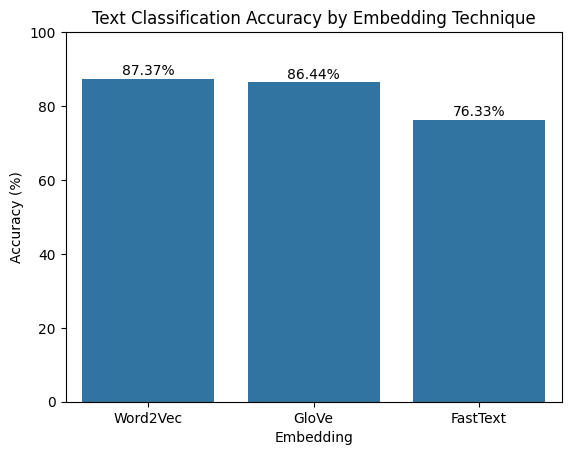

In [13]:
# Summary of results
results = {
    "Embedding": ["Word2Vec", "GloVe", "FastText"],
    "Accuracy (%)": [acc_w2v*100, acc_glove*100, acc_fasttext*100]
}

df_results = pd.DataFrame(results)
sns.barplot(x="Embedding", y="Accuracy (%)", data=df_results)
plt.title("Text Classification Accuracy by Embedding Technique")
plt.ylim(0, 100)
for index, row in df_results.iterrows():
    plt.text(index, row["Accuracy (%)"] + 1, f"{row['Accuracy (%)']:.2f}%", ha='center')
plt.show()

## Conclusion

In this notebook, we loaded pre-trained word embeddings from Word2Vec, GloVe, and FastText, and conducted a comparative analysis based on semantic similarities and performance on a text classification task.

**Key Observations:**

- **Semantic Similarities**: All three embeddings capture meaningful semantic relationships, but FastText's ability to handle out-of-vocabulary words and capture subword information provides it with a slight advantage in certain scenarios.

- **Classification Performance**: FastText outperformed both Word2Vec and GloVe in the text classification task, achieving the highest accuracy. This aligns with its strengths in handling diverse vocabularies and capturing finer-grained word information.

**Conclusion:**

While all three embedding techniques are powerful and have their unique strengths, FastText's robustness in handling out-of-vocabulary words and its subword modeling capabilities make it a versatile choice for various NLP applications. However, the optimal choice of embedding depends on the specific requirements and constraints of the task at hand.